In [1]:
import torch
import numpy as np
import gradoptics as optics
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

# Creating a scene, and producing an image

### Creating a scene

In [2]:
f = 0.05 # focal length (meters)
m = 0.15 # magnification

image_pof = -f * (1 + m)
object_pof = f * (1 + m) / m

# Creating a (thin) lens
lens = optics.PerfectLens(f=f, na=1 / 1.4, position=[0., 0., 0.], m=m)

## Creating a sensor
sensor = optics.Sensor(resolution=(9600, 9600), pixel_size=(3.76e-6, 3.76e-6), 
                       position=(image_pof, 0, 0), poisson_noise_mean=2, 
                       quantum_efficiency=0.8)

# Creating an Atom Cloud (which is a distribution)
atom_cloud = optics.AtomCloud(n=int(1e6), f=2, position=[object_pof, 0., 0.], phi=0.1)

# Wrapping the atom cloud to a light source, which will allow to sample photons
light_source = optics.LightSourceFromDistribution(atom_cloud)

# Creating a scene
scene = optics.Scene(light_source)
scene.add_object(lens) # Adding the lens to the scene
scene.add_object(sensor) # Adding the sensor to the scene

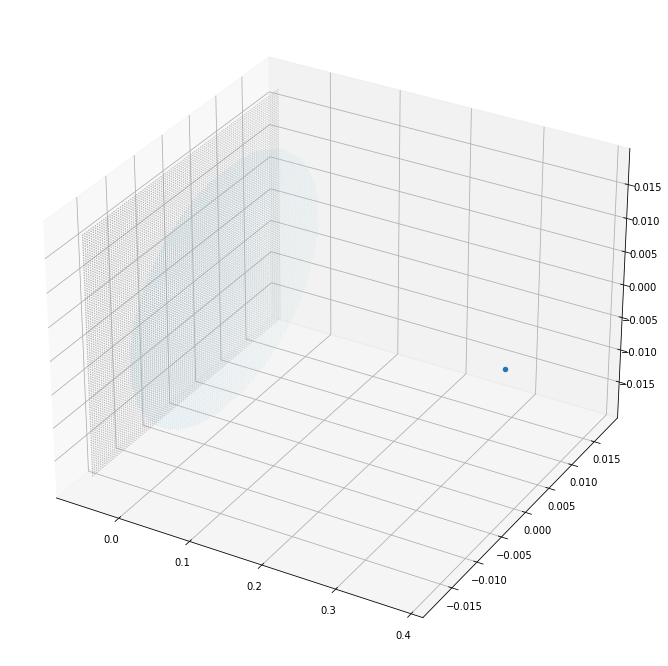

In [3]:
# Vizualizing the scene
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
scene.plot(ax)

### Producing an image from scratch

In [4]:
# Let us use the cpu for simplicity (everything will be much faster on GPU)
device = 'cpu'

# Let us start by sampling 10M rays (i.e. 10M photons) from the light source
rays = light_source.sample_rays(10_000_000, device=device)

# Computing the time at which the rays will intersect the lens
t = lens.get_ray_intersection(rays)
# Some rays do not intersect the lens, throw them away
mask = ~torch.isnan(t)
# Computing the rays refracted by the lens
refracted_rays, _ = lens.intersect(rays[mask], t[mask])

# Repeating the operations on the sensor for the refracted rays
t = sensor.get_ray_intersection(refracted_rays)
mask = ~torch.isnan(t)
sensor.intersect(refracted_rays[mask], t[mask])

# Readout the sensor
produced_image = sensor.readout(add_poisson_noise=False).data.cpu().numpy()

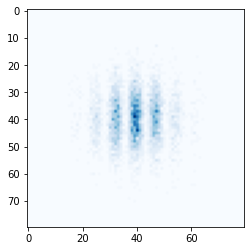

In [5]:
c = (4800, 4800)
w = 40
plt.imshow(produced_image[c[0] - w : c[0] + w, c[1] - w : c[1] + w], cmap='Blues')

### Producing an image with forward ray tracing

Alternatively, the built-in function forward_ray_tracing can be used

#### Rejection sampling
- The positions of the photons are sampled with respect to the density of the light source (using rejection sampling for unnormalized densities), and each photon carries the same amount of luminosity

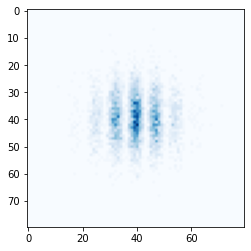

In [6]:
rays = light_source.sample_rays(10_000_000, device=device) # Sampling the photons with rejection sampling
optics.forward_ray_tracing(rays, scene, max_iterations=2)

# Readout the sensor
produced_image = sensor.readout(add_poisson_noise=False).data.cpu().numpy()

plt.imshow(produced_image[c[0] - w : c[0] + w, c[1] - w : c[1] + w], cmap='Blues')

#### Importance sampling
- The positions of the photons are sampled with respect to a proposal density (e.g. uniform, gaussian, ...), and the luminosity each photon carries is weighted with respect to the light source and proposal densities

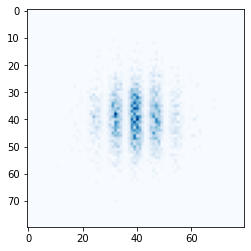

In [7]:
proposal_distribution = MultivariateNormal(torch.tensor([object_pof, 0, 0]), torch.eye(3) * 0.0002**2)
ray_origins = proposal_distribution.sample((10_000_000,))
ray_luminosities = light_source.pdf(ray_origins) / proposal_distribution.log_prob(ray_origins).exp()
# Samples rays in 4 pi
azimuthal_angle = torch.rand(ray_origins.shape[0]) * 2 * np.pi
polar_angle = torch.arccos(1 - 2 * torch.rand(ray_origins.shape[0]))
ray_directions = optics.batch_vector(torch.sin(polar_angle) * torch.sin(azimuthal_angle),
                                     torch.sin(polar_angle) * torch.cos(azimuthal_angle),
                                     torch.cos(polar_angle))
rays = optics.Rays(ray_origins, ray_directions, luminosities=ray_luminosities)
        
optics.forward_ray_tracing(rays, scene, max_iterations=2)

# Readout the sensor
produced_image = sensor.readout(add_poisson_noise=False).data.cpu().numpy()

plt.imshow(produced_image[c[0] - w : c[0] + w, c[1] - w : c[1] + w], cmap='Blues')

### Producing an image with backward ray tracing

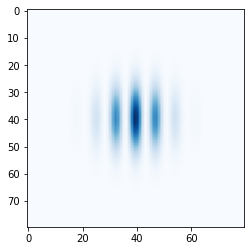

In [8]:
# The built-in fucntion backward_ray_tracing can also be used

# Light sources need a bounding shape for being used with backward ray tracing
light_source_bounding_shape = optics.BoundingSphere(radii=1e-3, xc=object_pof, yc=0.0, zc=0.0)
light_source = optics.LightSourceFromDistribution(atom_cloud, bounding_shape=light_source_bounding_shape)

# Computing incident rays from the sensor
N = 40
px_j, px_i = torch.meshgrid(torch.linspace(N, -N + 1, steps=N * 2), torch.linspace(N, -N + 1, steps=N * 2))
px_j = px_j.reshape(-1, 1).type(torch.long)
px_i = px_i.reshape(-1, 1).type(torch.long)
pos_x = (px_i - 0.5) * sensor.pixel_size[0]
pos_y = (px_j - 0.5) * sensor.pixel_size[1]
pos_z = torch.zeros(pos_x.shape)
origins = torch.cat((pos_x, pos_y, pos_z), dim=1)
origins = sensor.c2w.apply_transform_(origins)
directions = optics.batch_vector(- origins[:, 0], - origins[:, 1], - origins[:, 2])
incident_rays = optics.Rays(origins, directions, device=device)

# Producing an image with backward ray tracing
integrator = optics.StratifiedSamplingIntegrator(100)
image = optics.backward_ray_tracing(incident_rays, scene, light_source, integrator, max_iterations=2)
image = image.reshape(2 * N, 2 * N).data.cpu().numpy()

plt.imshow(image, cmap='Blues')